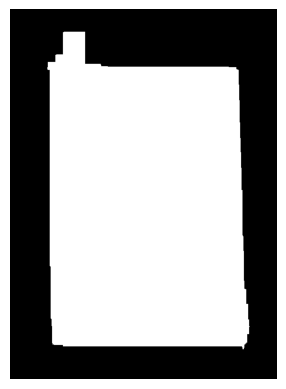

In [24]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image_path = r"C:\Users\User\OneDrive\Escritorio\Master\C1\Project\Team1\image.png"
img = cv.imread(image_path)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
_, binary = cv.threshold(gray, 128, 255, cv.THRESH_BINARY)

plt.imshow(cv.cvtColor(binary, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Ajustant rectangle perque contingui el centre de la imatge
score=36628.0, box=(124,72)-(516,196), white_in=40268, area=48608


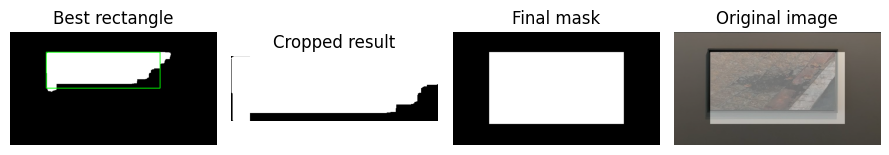

: 

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


mask_path = r"C:\Users\User\OneDrive\Escritorio\Master\C1\Project\Team1\visual\00025_output_mask.png"
original_image_path = r"C:\Users\User\OneDrive\Escritorio\Master\C1\Project\Team1\visual\00025_img.jpg"    

lam = 1.0          
min_side = 40     
coarse_step = 16   
fine_step = 4      
pad = 2            

mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
if mask is None:
    raise FileNotFoundError(mask_path)
_, bw = cv.threshold(mask, 127, 255, cv.THRESH_BINARY)
H, W = bw.shape

bw01 = (bw > 0).astype(np.uint8)

I = cv.integral(bw01).astype(np.int64) # white

def rect_sum(ii, x0, y0, x1, y1):
    """sum of ones in [y0:y1, x0:x1] inclusive-exclusive"""
    return ii[y1, x1] - ii[y0, x1] - ii[y1, x0] + ii[y0, x0]

def search(step):
    best = (-1e18, 0, 0, 0, 0)
    for y0 in range(0, H - min_side + 1, step):
        for x0 in range(0, W - min_side + 1, step):
            for y1 in range(y0 + min_side, H + 1, step):
                for x1 in range(x0 + min_side, W + 1, step):
                    white_in = rect_sum(I, x0, y0, x1, y1)
                    area = (y1 - y0) * (x1 - x0)
                    black_in = area - white_in
                    score = white_in - lam * black_in
                    if score > best[0]:
                        best = (score, x0, y0, x1, y1)
    return best

score, x0, y0, x1, y1 = search(coarse_step)

x0r = max(x0 - 2*coarse_step, 0)
y0r = max(y0 - 2*coarse_step, 0)
x1r = min(x1 + 2*coarse_step, W)
y1r = min(y1 + 2*coarse_step, H)

best = (-1e18, x0, y0, x1, y1)
for Y0 in range(y0r, min(y0r + 4*coarse_step, H - min_side + 1), fine_step):
    for X0 in range(x0r, min(x0r + 4*coarse_step, W - min_side + 1), fine_step):
        for Y1 in range(max(Y0 + min_side, y1r - 4*coarse_step), y1r + 1, fine_step):
            for X1 in range(max(X0 + min_side, x1r - 4*coarse_step), x1r + 1, fine_step):
                white_in = rect_sum(I, X0, Y0, X1, Y1)
                area = (Y1 - Y0) * (X1 - X0)
                black_in = area - white_in
                score = white_in - lam * black_in
                if score > best[0]:
                    best = (score, X0, Y0, X1, Y1)

score, x0, y0, x1, y1 = best

x0p = max(x0 - pad, 0); y0p = max(y0 - pad, 0)
x1p = min(x1 + pad, W); y1p = min(y1 + pad, H)

center_of_img = (W//2, H//2)

if not (x0 <= center_of_img[0] <= x1 and y0 <= center_of_img[1] <= y1):
    print("Ajustant rectangle perque contingui el centre de la imatge")
      
    cx, cy = center_of_img

    if cx < x0:
        x0 = cx
    elif cx >= x1:
        x1 = min(cx + 1, W) 

    if cy < y0:
        y0 = cy
    elif cy >= y1:
        y1 = min(cy + 1, H) 

    x0 = max(0, x0); y0 = max(0, y0)
    x1 = min(W, x1); y1 = min(H, y1)

    crop = bw[y0:y1, x0:x1]
    final_mask = np.zeros_like(bw)
    final_mask[y0:y1, x0:x1] = 255

else:

    crop = bw[y0p:y1p, x0p:x1p]
    final_mask = np.zeros_like(bw)
    final_mask[y0p:y1p, x0p:x1p] = 255


rgb = cv.cvtColor(bw, cv.COLOR_GRAY2RGB)
cv.rectangle(rgb, (x0, y0), (x1-1, y1-1), (0,255,0), 2) 

# Mirror a final_image

# fer quadrant
Hc, Wc = final_mask.shape
top_left = final_mask[0:Hc//2, 0:Wc//2]
top_right = final_mask[0:Hc//2, Wc//2:Wc]
bottom_left = final_mask[Hc//2:Hc, 0:Wc//2]
bottom_right = final_mask[Hc//2:Hc, Wc//2:Wc]

# buscar el que te mes pixels blancs
quadrants = [top_left, top_right, bottom_left, bottom_right]
max_white = -1
best_quadrant = None
for q in quadrants:
    white_pixels = np.sum(q == 255)
    if white_pixels > max_white:
        max_white = white_pixels
        best_quadrant = q

# fer mirror  
if best_quadrant is top_left:
    top = np.hstack((best_quadrant, cv.flip(best_quadrant, 1)))
    bottom = cv.flip(top, 0)
    mirrored = np.vstack((top, bottom))
elif best_quadrant is top_right:
    top = np.hstack((cv.flip(best_quadrant, 1), best_quadrant))
    bottom = cv.flip(top, 0)
    mirrored = np.vstack((top, bottom))
elif best_quadrant is bottom_left:
    bottom = np.hstack((best_quadrant, cv.flip(best_quadrant, 1)))
    top = cv.flip(bottom, 0)
    mirrored = np.vstack((top, bottom))
else:  
    bottom = np.hstack((cv.flip(best_quadrant, 1), best_quadrant))
    top = cv.flip(bottom, 0)
    mirrored = np.vstack((top, bottom))

final_mask = mirrored # Aqui posar if 

plt.figure(figsize=(9,4))
plt.subplot(1,4,1); plt.title("Best rectangle"); plt.imshow(rgb); plt.axis('off')
plt.subplot(1,4,2); plt.title("Cropped result"); plt.imshow(crop, cmap='gray'); plt.axis('off')
plt.subplot(1,4,3); plt.title("Final mask"); plt.imshow(final_mask, cmap='gray'); plt.axis('off')
plt.subplot(1,4,4); plt.title("Original image"); plt.imshow(cv.cvtColor(cv.imread(original_image_path), cv.COLOR_BGR2RGB)); plt.imshow(final_mask, cmap='gray', alpha=0.45); plt.axis('off')
plt.tight_layout()

cv.imwrite("final_mask.png", final_mask)
cv.imwrite("firtst_crop.png", rgb)
cv.imwrite("img10.png", cv.imread(original_image_path))

print(f"score={score}, box=({x0},{y0})-({x1},{y1}), white_in={rect_sum(I,x0,y0,x1,y1)}, area={(y1-y0)*(x1-x0)}")